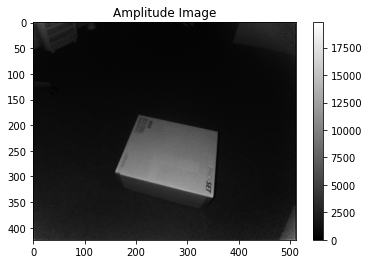

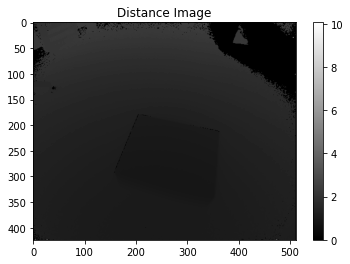

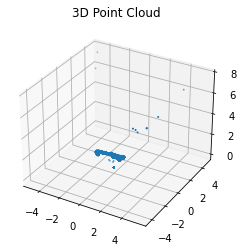

In [1]:
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load data
def load_data(file_path):
    # Load .mat file
    data = scipy.io.loadmat(file_path)
    return data[list(data.keys())[3]], data[list(data.keys())[4]], data[list(data.keys())[5]]

# Visualization functions
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, :, 0], pc[:, :, 1], pc[:, :, 2], s=1)
    ax.set_title('3D Point Cloud')
    plt.show()

# Load your data
amplitude_image, distance_image, point_cloud = load_data('data/example2kinect.mat')

# Display images
show_image(amplitude_image, 'Amplitude Image')
show_image(distance_image, 'Distance Image')

# Display point cloud
show_point_cloud(point_cloud)


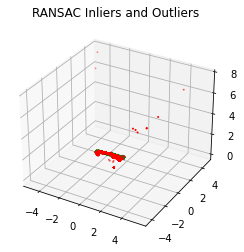

In [2]:
import numpy as np

def ransac_point_cloud(pc, threshold, max_iterations):
    best_plane = None
    best_inliers = []
    best_indices = None  # To store the indices of the best inliers

    for _ in range(max_iterations):
        # Randomly sample 3 points to define a plane
        sample_indices = np.random.choice(pc.shape[0] * pc.shape[1], 3, replace=False)
        samples = pc.reshape(-1, 3)[sample_indices]

        if np.any(samples[:, 2] == 0):  # Skip if any z-component is zero (invalid data)
            continue

        # Calculate plane parameters
        p1, p2, p3 = samples
        normal_vector = np.cross(p2 - p1, p3 - p1)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        d = -np.dot(normal_vector, p1)

        # Count inliers
        all_points = pc.reshape(-1, 3)
        distances = np.abs(np.dot(all_points, normal_vector) + d) / np.linalg.norm(normal_vector)
        inliers = distances < threshold

        # Update best model if current one has more inliers
        if inliers.sum() > len(best_inliers):
            best_plane = (normal_vector, d)
            best_inliers = inliers
            best_indices = np.argwhere(inliers.reshape(pc.shape[0], pc.shape[1]))  # Store the 2D indices

    return best_plane, best_inliers, best_indices

# Parameters
threshold = 0.085  # Distance threshold for inliers
max_iterations = 3000  # Maximum number of iterations

# Assuming point_cloud is the loaded 3D point cloud data
plane, inliers, inlier_indices = ransac_point_cloud(point_cloud, threshold, max_iterations)


def visualize_inliers_on_image(image, inlier_indices, title="Inliers Overlay"):
    plt.imshow(image, cmap='gray')
    plt.scatter(inlier_indices[:, 1], inlier_indices[:, 0], color='red', s=1)  # x, y are inverted for scatter
    plt.title(title)
    plt.show()

# Assuming amplitude_image is loaded and corresponds spatially to the point cloud
visualize_inliers_on_image(amplitude_image[:, :, 0], inlier_indices, "Inliers on Amplitude Image")



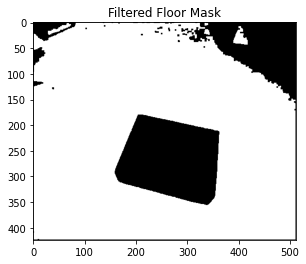

In [3]:
import scipy.ndimage as ndimage

def apply_morphological_filters(binary_mask, size=3):
    # Apply binary closing and opening to remove noise and fill gaps
    structure = np.ones((size, size))
    closed_mask = ndimage.binary_closing(binary_mask, structure=structure)
    cleaned_mask = ndimage.binary_opening(closed_mask, structure=structure)
    return cleaned_mask

# Convert inliers to a binary mask
binary_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
binary_mask[inliers.reshape(point_cloud.shape[:2])] = True

# Apply morphological filtering
cleaned_mask = apply_morphological_filters(binary_mask)


# Visualization function for the mask
def show_mask(mask, title):
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.show()

show_mask(cleaned_mask, 'Filtered Floor Mask')


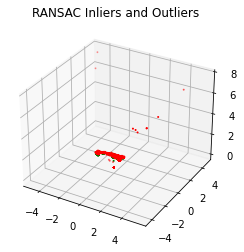

In [4]:
def extract_non_floor_points(pc, mask):
    # Reshape and mask the point cloud to exclude floor points
    flat_mask = mask.reshape(-1)
    non_floor_points = pc.reshape(-1, 3)[~flat_mask]
    return non_floor_points.reshape((np.sum(~flat_mask), 1, 3))

# Extract non-floor points
non_floor_pc = extract_non_floor_points(point_cloud, cleaned_mask)

# Apply RANSAC to find the top plane of the box
top_plane, top_inliers = ransac_point_cloud(non_floor_pc, threshold, max_iterations)

# Visualize the inliers for the top plane
visualize_inliers(non_floor_pc, top_inliers)


In [5]:
print(non_floor_pc.shape)
print(point_cloud.shape)
print(inliers.shape)
print(top_inliers.shape)

(46337, 1, 3)
(424, 512, 3)
(217088,)
(46337,)


In [6]:
top_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
top_mask[top_inliers.reshape(point_cloud.shape[:2])] = True

cleaned_top_mask = apply_morphological_filters(top_mask, size=3)

show_mask(cleaned_top_mask, 'Filtered Top Mask')

ValueError: cannot reshape array of size 46337 into shape (424,512)

In [ ]:
def calculate_plane_distance(plane1, plane2):
    # Extract the normal vector (n) and the constant (d) from plane equations
    n1, d1 = plane1
    n2, d2 = plane2

    # Assuming planes are parallel, calculate distance between them
    # Distance formula between two parallel planes |d1 - d2| / |n| (where n is the same for both planes)
    # if np.allclose(n1, n2) or np.allclose(n1, -n2):
    distance = np.abs(d1 - d2) / np.linalg.norm(n1 - n2)
    # else:
    #     raise ValueError("Planes are not parallel, check the RANSAC results.")
    return distance

# Calculate height of the box
box_height = calculate_plane_distance(plane, top_plane)
print(f"The estimated height of the box is: {box_height:.2f} units")


In [ ]:
import scipy.ndimage as ndi

def find_largest_connected_component(mask):
    # Label connected components
    labeled, num_features = ndi.label(mask)
    # Find the largest component
    sizes = ndi.sum(mask, labeled, range(num_features + 1))
    max_label = sizes.argmax()
    largest_component = (labeled == max_label)
    return largest_component

# Convert top inliers to a binary mask
top_binary_mask = np.zeros(non_floor_pc.shape[:2], dtype=bool)
top_binary_mask[top_inliers.reshape(non_floor_pc.shape[:2])] = True

# Find the largest connected component
largest_component = find_largest_connected_component(top_binary_mask)

# Calculate bounding box of the largest component
slice_x, slice_y = ndi.find_objects(largest_component)[0]
box_length = slice_y.stop - slice_y.start
box_width = slice_x.stop - slice_x.start

print(f"The estimated length of the box is: {box_length} units")
print(f"The estimated width of the box is: {box_width} units")

# Optional: Visualize the largest connected component
show_mask(largest_component, 'Largest Component Mask')
